The goal of this lab is to explore hyperparameter search/tuning with the package [Optuna](https://https://optuna.org/)

As before, firstly, we will start with the familiar [MNIST](https://https://en.wikipedia.org/wiki/MNIST_database) dataset.

However, first of all, let's just install the Optuna library:

In [67]:
pip install optuna

# Importing needed libraries

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings
import optuna

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import *
#from tf.keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

# Utility functions

In [5]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# Main section

Let's import and prepare the MNIST dataset first as we did in the previous lab.

In [6]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


In [8]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] # 28 * 28
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(60000, 784)


In [9]:
print("First 5 training labels: ", y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(60000, 10)



Again, we will start by defining the model from the Sequential() function and adding some Dense (fully-connected) layers.
Here we will be starting with a simple network with just a single hidden layer with 32 neurons.
Make sure you set the size of the output layer to be the number of classes that we are trying to predict!
We can have a look at our model using the model.summary() function

In [62]:
#image_size = 784 # 28*28
#num_classes = 10 # ten unique digits
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_235"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_470 (Dense)           (None, 32)                25120     
                                                                 
 dense_471 (Dense)           (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


Let's compile our model, train for for 5 epochs and examine the perfomance

In [63]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.1547 - accuracy: 0.3891 - val_loss: 1.9444 - val_accuracy: 0.6567
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 1.7962 - accuracy: 0.6658 - val_loss: 1.6156 - val_accuracy: 0.7257
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.5083 - accuracy: 0.7174 - val_loss: 1.3449 - val_accuracy: 0.7798
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 1.2813 - accuracy: 0.7592 - val_loss: 1.1387 - val_accuracy: 0.8152
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.1106 - accuracy: 0.7875 - val_loss: 0.9852 - val_accuracy: 0.8360


Test loss: 1.02
Test accuracy: 0.814


<Figure size 576x432 with 0 Axes>

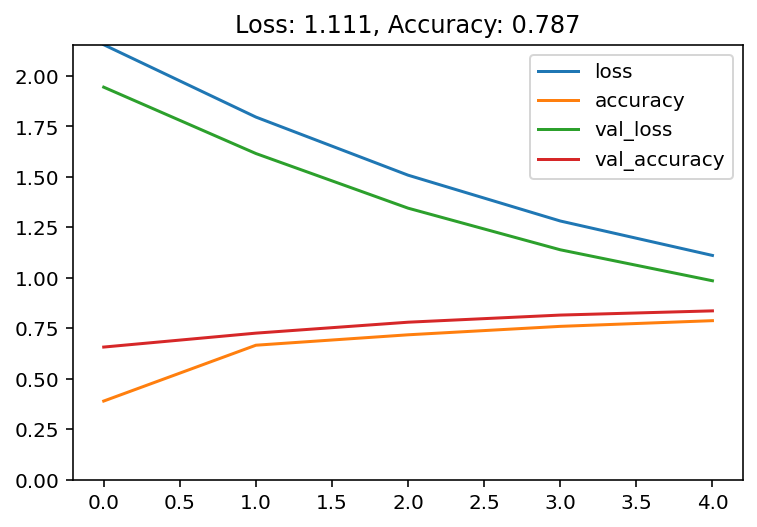

In [65]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

As we can see above, the perfomance of our model is not too bad. 

We did try default learning rate, so, for our SGD optimizer. Can you tell what the value of the defaul learning rate we used? Hint: See documentaion for Keras SGD optimizer.

Learning rate is a **hyperparameter**, because we set it before we started the training process. What if we can tune the learning rate and choose the one which gives us better result on the validation set instead?

We could try different values by hand (for example, 0.1, 0.2, 0.3) but it might take some time. Why not to use better search strategies? Let's use a package called **Optuna**.

Below, we will set up so called **Trial**, where we define our model, hyperparameters that we would like to examine - learning rate and the objective function - accuracy on the validation set after 5 epochs.  
We will sample various learning rates between 1e-5 and 1e-1 (uniformly distributed on the logarithmic scale).  



In [31]:
def objective(trial):
    model = build_basic_model()
    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True) #sample value of learning rate between 1e-5 and 1e-1
    model.compile(tf.keras.optimizers.SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc #we will use validation accuracy to compare perfomance of models trained with sample learning rates

Next we will sample 10 different learning rates and evaluate perfomance. It might take a bit of time, that's why we only use 5 epochs. 

In [32]:
study = optuna.create_study(direction='maximize') # we would like to maximise the validation accuracy
study.optimize(objective, n_trials=10) #use objective function defined above and sample 10 different learning rates

[I 2022-03-29 02:46:43,361] A new study created in memory with name: no-name-554913b4-8809-4b48-b820-c9cd84501b14


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3368 - accuracy: 0.1581 - val_loss: 2.3341 - val_accuracy: 0.1685
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3355 - accuracy: 0.1585 - val_loss: 2.3329 - val_accuracy: 0.1690
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3343 - accuracy: 0.1587 - val_loss: 2.3316 - val_accuracy: 0.1690
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3331 - accuracy: 0.1590 - val_loss: 2.3304 - val_accuracy: 0.1698
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3319 - accuracy: 0.1593 - val_loss: 2.3292 - val_accuracy: 0.1698


[I 2022-03-29 02:46:50,728] Trial 0 finished with value: 0.16983333230018616 and parameters: {'lr': 1.3268937411013897e-05}. Best is trial 0 with value: 0.16983333230018616.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2290 - accuracy: 0.2596 - val_loss: 2.1022 - val_accuracy: 0.4833
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.0276 - accuracy: 0.5498 - val_loss: 1.9253 - val_accuracy: 0.6223
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.8652 - accuracy: 0.6229 - val_loss: 1.7618 - val_accuracy: 0.6808
Epoch 4/5
422/422 [==============================] - 1s 4ms/step - loss: 1.7143 - accuracy: 0.6671 - val_loss: 1.6102 - val_accuracy: 0.7187
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.5755 - accuracy: 0.6971 - val_loss: 1.4715 - val_accuracy: 0.7455


[I 2022-03-29 02:47:01,424] Trial 1 finished with value: 0.7455000281333923 and parameters: {'lr': 0.004996012337055678}. Best is trial 1 with value: 0.7455000281333923.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 1.1998 - accuracy: 0.7529 - val_loss: 0.6138 - val_accuracy: 0.8840
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5552 - accuracy: 0.8691 - val_loss: 0.4007 - val_accuracy: 0.9088
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4283 - accuracy: 0.8895 - val_loss: 0.3299 - val_accuracy: 0.9170
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.3731 - accuracy: 0.9003 - val_loss: 0.2947 - val_accuracy: 0.9225
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.3406 - accuracy: 0.9069 - val_loss: 0.2708 - val_accuracy: 0.9280


[I 2022-03-29 02:47:09,459] Trial 2 finished with value: 0.9279999732971191 and parameters: {'lr': 0.09852514553006246}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.4543 - accuracy: 0.1144 - val_loss: 2.4673 - val_accuracy: 0.1087
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 2.4519 - accuracy: 0.1149 - val_loss: 2.4648 - val_accuracy: 0.1088
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 2.4495 - accuracy: 0.1151 - val_loss: 2.4623 - val_accuracy: 0.1093
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.4471 - accuracy: 0.1153 - val_loss: 2.4598 - val_accuracy: 0.1095
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.4448 - accuracy: 0.1154 - val_loss: 2.4574 - val_accuracy: 0.1100


[I 2022-03-29 02:47:17,869] Trial 3 finished with value: 0.10999999940395355 and parameters: {'lr': 1.4784295585109726e-05}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3849 - accuracy: 0.1042 - val_loss: 2.3891 - val_accuracy: 0.1095
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3835 - accuracy: 0.1048 - val_loss: 2.3877 - val_accuracy: 0.1102
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3822 - accuracy: 0.1055 - val_loss: 2.3863 - val_accuracy: 0.1105
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3808 - accuracy: 0.1060 - val_loss: 2.3849 - val_accuracy: 0.1118
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3795 - accuracy: 0.1065 - val_loss: 2.3836 - val_accuracy: 0.1130


[I 2022-03-29 02:47:28,571] Trial 4 finished with value: 0.11299999803304672 and parameters: {'lr': 1.3927324263150126e-05}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 5ms/step - loss: 2.1007 - accuracy: 0.4521 - val_loss: 1.8956 - val_accuracy: 0.6503
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 1.7462 - accuracy: 0.6729 - val_loss: 1.5610 - val_accuracy: 0.7475
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.4535 - accuracy: 0.7377 - val_loss: 1.2885 - val_accuracy: 0.7990
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 1.2253 - accuracy: 0.7752 - val_loss: 1.0839 - val_accuracy: 0.8342
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.0571 - accuracy: 0.8017 - val_loss: 0.9344 - val_accuracy: 0.8487


[I 2022-03-29 02:47:36,942] Trial 5 finished with value: 0.8486666679382324 and parameters: {'lr': 0.010689178513877401}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.4412 - accuracy: 0.1046 - val_loss: 2.4307 - val_accuracy: 0.1032
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.4140 - accuracy: 0.1102 - val_loss: 2.4045 - val_accuracy: 0.1102
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3902 - accuracy: 0.1178 - val_loss: 2.3814 - val_accuracy: 0.1185
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3691 - accuracy: 0.1273 - val_loss: 2.3609 - val_accuracy: 0.1267
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3502 - accuracy: 0.1404 - val_loss: 2.3424 - val_accuracy: 0.1433


[I 2022-03-29 02:47:44,598] Trial 6 finished with value: 0.1433333307504654 and parameters: {'lr': 0.00014225828772657765}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 1.6919 - accuracy: 0.6469 - val_loss: 1.1327 - val_accuracy: 0.8323
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.9287 - accuracy: 0.8227 - val_loss: 0.6868 - val_accuracy: 0.8777
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.6600 - accuracy: 0.8559 - val_loss: 0.5187 - val_accuracy: 0.8955
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.5408 - accuracy: 0.8730 - val_loss: 0.4343 - val_accuracy: 0.9052
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4738 - accuracy: 0.8831 - val_loss: 0.3842 - val_accuracy: 0.9108


[I 2022-03-29 02:47:51,979] Trial 7 finished with value: 0.9108333587646484 and parameters: {'lr': 0.043991002888844624}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.5800 - accuracy: 0.0990 - val_loss: 2.4134 - val_accuracy: 0.0952
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3426 - accuracy: 0.1019 - val_loss: 2.2953 - val_accuracy: 0.1052
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2632 - accuracy: 0.1284 - val_loss: 2.2353 - val_accuracy: 0.1425
Epoch 4/5
422/422 [==============================] - 1s 4ms/step - loss: 2.2160 - accuracy: 0.1608 - val_loss: 2.1934 - val_accuracy: 0.1802
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.1805 - accuracy: 0.2196 - val_loss: 2.1592 - val_accuracy: 0.2573


[I 2022-03-29 02:48:02,648] Trial 8 finished with value: 0.25733333826065063 and parameters: {'lr': 0.0007302174363653532}. Best is trial 2 with value: 0.9279999732971191.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.2820 - accuracy: 0.1305 - val_loss: 2.2018 - val_accuracy: 0.2273
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.1535 - accuracy: 0.3462 - val_loss: 2.1025 - val_accuracy: 0.4800
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 2.0669 - accuracy: 0.5341 - val_loss: 2.0157 - val_accuracy: 0.6225
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 1.9859 - accuracy: 0.6106 - val_loss: 1.9322 - val_accuracy: 0.6687
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.9071 - accuracy: 0.6436 - val_loss: 1.8508 - val_accuracy: 0.6947


[I 2022-03-29 02:48:13,396] Trial 9 finished with value: 0.6946666836738586 and parameters: {'lr': 0.002403823551223423}. Best is trial 2 with value: 0.9279999732971191.


In [18]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

Let's see how our validation accuracy (Y axis) changed during 10 trials

In [33]:
plot_optimization_history(study)

Let's see what was the best value (gives best validation accuracy) of learning rate which Optuna found. Is it different from the default value of the Keras SGD optimiser?

In [34]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.9279999732971191
  Params: 
    lr: 0.09852514553006246


In [46]:
print(study.best_params['lr'])

0.09852514553006246


Finally, let's use use this new learning rate, train our model and evaluate perfomance on the test set. Did we get improved result?

In [66]:
model = build_basic_model()
# We compile our model with a sampled learning rate.
lr=study.best_params['lr']
#lr=0.01
model.compile(tf.keras.optimizers.SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)


loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 1.2246 - accuracy: 0.7400 - val_loss: 0.6122 - val_accuracy: 0.8872
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.5482 - accuracy: 0.8716 - val_loss: 0.3915 - val_accuracy: 0.9102
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4225 - accuracy: 0.8906 - val_loss: 0.3230 - val_accuracy: 0.9187
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.3702 - accuracy: 0.9003 - val_loss: 0.2880 - val_accuracy: 0.9238
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.3386 - accuracy: 0.9066 - val_loss: 0.2670 - val_accuracy: 0.9268
Test loss: 0.31
Test accuracy: 0.915


Try to explore with tuning other hyperparameters in the model and see what happens. To tune categorial parameters, such as optmiser name, please see here: [categorical](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical)